# Introduction

Notebook to analyze the **False Positive** Results for each model in the context of traceability between **test cases** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.tc_br_models_runner import TC_BR_Runner
from modules.utils import model_evaluator as m_eval
from modules.utils import aux_functions
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = TC_BR_Runner()

lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle=fd.Tc_BR_Oracles.read_oracle_volunteers_df()

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[10,20,40], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

TestCases.shape: (195, 12)
SelectedBugReports.shape: (91, 18)
Running LSI Model ------
Running LDA Model -----
Running BM25 Model -----
Running W2V Model ------
OracleVolunteers.shape: (195, 91)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
testcases['tokens'] = testcases.apply(lambda row : tokenizer.__call__(row['tc_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_10_cosine_0.0,33.08,23.46,26.09,precision recall fscore ...,0.0,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
1,lsi,top_10_cosine_0.1,33.08,23.46,26.09,precision recall fscore ...,0.1,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
2,lsi,top_10_cosine_0.2,33.08,23.46,26.09,precision recall fscore ...,0.2,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
3,lsi,top_10_cosine_0.3,33.08,23.46,26.09,precision recall fscore ...,0.3,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
4,lsi,top_10_cosine_0.4,32.99,23.28,25.97,precision recall fscore ...,0.4,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...


### Grouping Results by Model

### Min Precision

model
bm25          14.04
lda            4.23
lsi            9.07
wordvector     6.21
Name: perc_precision, dtype: float64



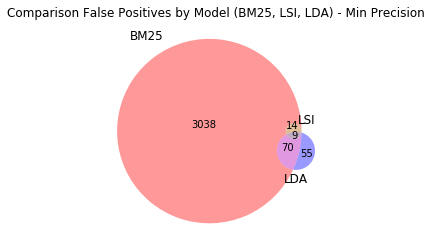

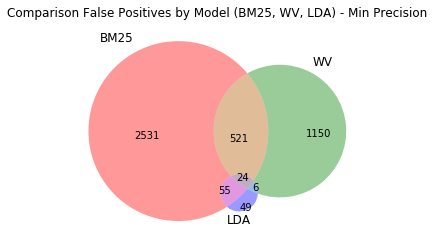

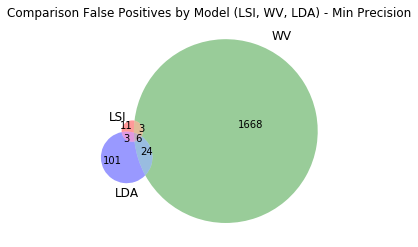

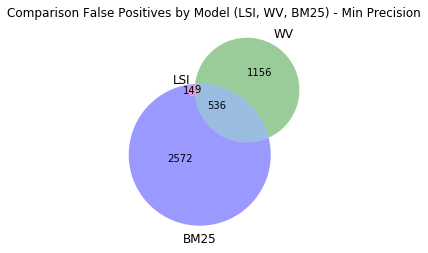

In [6]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [7]:
print("BM25 Exclusive FP:")
bm25_exc_set = bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FP:")
lsi_exc_set = lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FP:")
lda_exc_set = lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FP:")
wv_exc_set = wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FP:
len(bm25_exc_set): 2520


LSI Exclusive FP:
len(lsi_exc_set): 0


LDA Exclusive FP:
len(lda_exc_set): 49


WV Exclusive FP:
len(wv_exc_set): 1150


##### Word Clouds

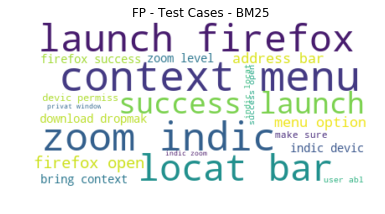

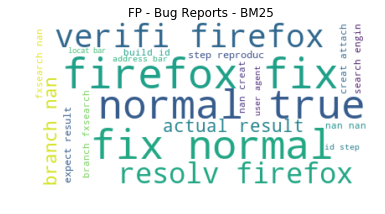

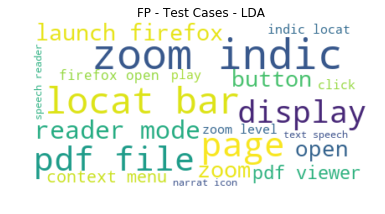

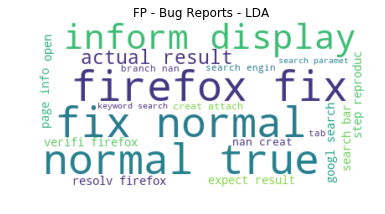

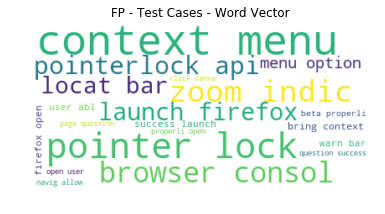

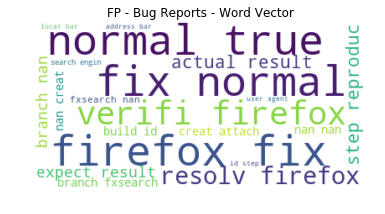

In [8]:
aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - BM25",
                                     wc_br_title="FP - Bug Reports - BM25")

#aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
#                                     wc_tc_title="FP - Test Cases - LSI",
#                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - Word Vector",
                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Positives Amount by Model

In [9]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 23
LDA FP Amount: 134
BM25 FP Amount: 3131
WV FP Amount: 1701


##### Detailing Features for Exclusive Sets

In [10]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_97_TRG,Context Menu,BR_1287823_SRC,[Linux] Dragging & dropping a download from the downloads panel on desktop saves a txt file
1,TC_23_TRG,New Awesome Bar,BR_1269348_SRC,Show last sync date tooltip on Synced Tabs sidebar device names
2,TC_36_TRG,Windows Child Mode,BR_1313778_SRC,"[Intermittent] Install Ecosia, Firebug, Theme Font & Size Changer"
3,TC_60_TRG,Browser Customization,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
4,TC_204_TRG,Zoom Indicator,BR_1287748_SRC,"Syncing away from lwtheme updates internal state / add-on manager UI, but not the actual browser"
5,TC_115_TRG,Text to Speech in Reader Mode,BR_1283542_SRC,Automigration from Chrome is broken
6,TC_64_TRG,Browser Customization,BR_1248267_SRC,"Right click on bookmark item of ""Recently Bookmarked"" should show regular places context menu"
7,TC_126_TRG,Pointer Lock API,BR_1305737_SRC,Change notification displayed when an incoming tab can't determine the device name it came from
8,TC_43_TRG,APZ - Async Scrolling,BR_1267480_SRC,Intermittent browser/components/preferences/in-content/tests/browser_security.jsThis test exceeded the timeout threshold. It should be rewritten or split up.
9,TC_79_TRG,Context Menu,BR_1297686_SRC,"When multiple desktop files support the same protocol scheme, only one of them is listed"


,tc,tc_feat,br,br_summary
0,TC_68_TRG,PDF Viewer,BR_1313290_SRC,Use browser specific message manager in `SocialShare.sharePage`
1,TC_119_TRG,Text to Speech in Reader Mode,BR_1353831_SRC,OneOff block in search bar doesn't update text if Customize was opened at least once
2,TC_65_TRG,PDF Viewer,BR_1296861_SRC,[control center] Don't hardcode colors for the permission status and permission removal button
3,TC_174_TRG,FLAC support,BR_1323211_SRC,Change Sync datatype label from Tabs to Open tabs
4,TC_120_TRG,WebGL Compatibility,BR_1313290_SRC,Use browser specific message manager in `SocialShare.sharePage`
5,TC_21_TRG,New Awesome Bar,BR_1312018_SRC,Keyword search is always performed in lowercase
6,TC_147_TRG,Zoom Indicator,BR_1320557_SRC,"No security information displayed for a specific website, using a specific Firefox profile"
7,TC_176_TRG,FLAC support,BR_1323211_SRC,Change Sync datatype label from Tabs to Open tabs
8,TC_150_TRG,Zoom Indicator,BR_1320557_SRC,"No security information displayed for a specific website, using a specific Firefox profile"
9,TC_61_TRG,Browser Customization,BR_1357085_SRC,Confirm your account pref screen should no longer redirect to Sync prefs


,tc,tc_feat,br,br_summary


,tc,tc_feat,br,br_summary
0,TC_122_TRG,WebGL Compatibility,BR_1339497_SRC,firefox tries to load incorrect url if urlbar autocomplete suggests first-two-letters-duplicated hosts when input url contains % encoded components
1,TC_133_TRG,Pointer Lock API,BR_1285041_SRC,Investigate Chrome profile migration importing history when chrome is running
2,TC_131_TRG,Pointer Lock API,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
3,TC_135_TRG,Pointer Lock API,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
4,TC_136_TRG,WebM EME support for Widevine,BR_1281190_SRC,Keep collecting telemetry for Permissions Notifications until version 55
5,TC_174_TRG,FLAC support,BR_1313778_SRC,"[Intermittent] Install Ecosia, Firebug, Theme Font & Size Changer"
6,TC_94_TRG,Context Menu,BR_1297374_SRC,"[One-off searches] When changing the default search engine from Awesomebar, the icon of the new default engine is replaced by the icon of the old default engine"
7,TC_34_TRG,Windows Child Mode,BR_1345687_SRC,[Regression] Clicking on audioVideoButton / sharing-icon don't work when typed on urlbar
8,TC_148_TRG,Zoom Indicator,BR_1297336_SRC,Device permission gone from the permission dropdown after detaching the tab to a new window
9,TC_105_TRG,Windows 10 Compatibility,BR_1264988_SRC,Scrollbar appears for a moment in the new Awesomebar Resultlist


#### Max Precision

model
bm25          21.21
lda           20.57
lsi           33.80
wordvector     6.85
Name: perc_precision, dtype: float64



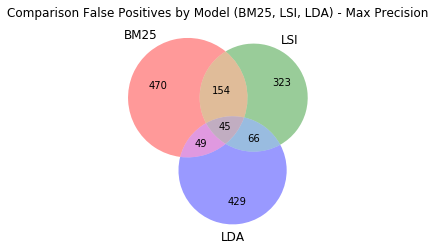

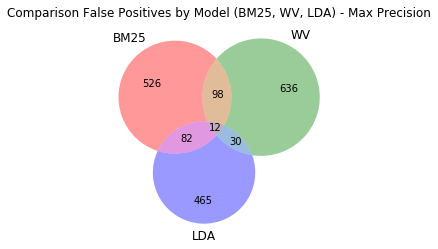

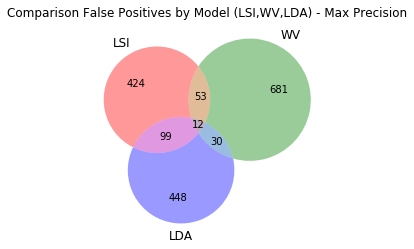

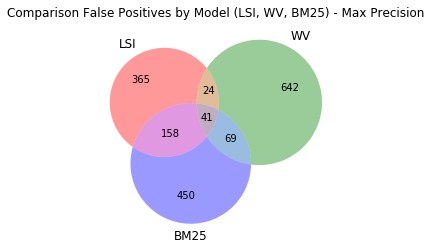

In [11]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [12]:
print("BM25 Exclusive FP:")
bm25_exc_set = bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FP:")
lsi_exc_set = lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FP:")
lda_exc_set = lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FP:")
wv_exc_set = wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FP:
len(bm25_exc_set): 405


LSI Exclusive FP:
len(lsi_exc_set): 303


LDA Exclusive FP:
len(lda_exc_set): 403


WV Exclusive FP:
len(wv_exc_set): 616


##### Word Clouds

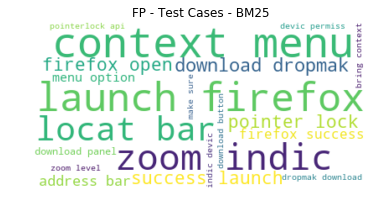

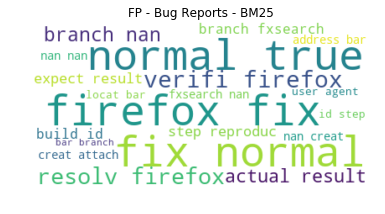

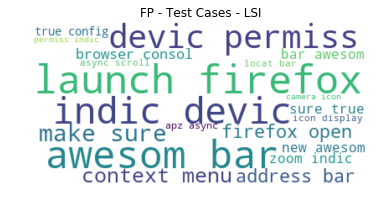

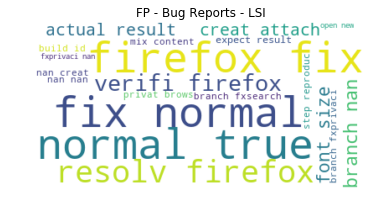

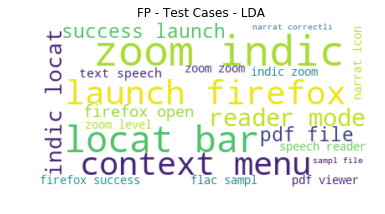

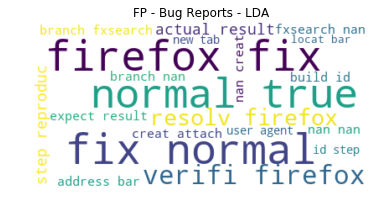

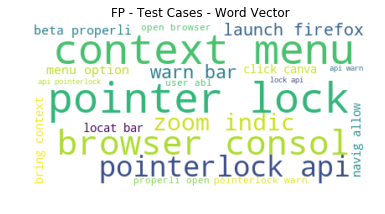

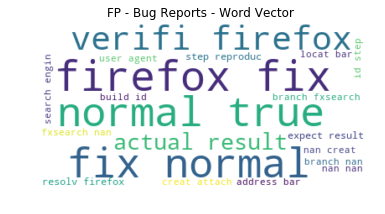

In [13]:
aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - BM25",
                                     wc_br_title="FP - Bug Reports - BM25")

aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LSI",
                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - Word Vector",
                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Positives Amount by Model

In [14]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 588
LDA FP Amount: 589
BM25 FP Amount: 718
WV FP Amount: 776


##### Detailing Features for Exclusive Sets

In [15]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_154_TRG,Downloads Dropmaker,BR_1281190_SRC,Keep collecting telemetry for Permissions Notifications until version 55
1,TC_36_TRG,Windows Child Mode,BR_1313778_SRC,"[Intermittent] Install Ecosia, Firebug, Theme Font & Size Changer"
2,TC_159_TRG,Downloads Dropmaker,BR_1302468_SRC,Firefox Beta reports channel as 'release' when build is RC due to use of Services.appinfo.defaultUpdateChannel
3,TC_183_TRG,Indicator for device permissions,BR_1334844_SRC,"Address bar uses most recently entered URL, not URL in bar, after using CTRL+ENTER"
4,TC_49_TRG,APZ - Async Scrolling,BR_1335992_SRC,Search with default search engine stops working
5,TC_159_TRG,Downloads Dropmaker,BR_1271607_SRC,The new window's size is modified if the last closed window had pinned tabs
6,TC_180_TRG,Indicator for device permissions,BR_1318903_SRC,"[Windows 7 and below] Fullscreen window controls not shown with dark themes, close button has broken ""red square"" hover state"
7,TC_88_TRG,Context Menu,BR_1301421_SRC,browser.fixup.dns_first_for_single_words prevents location bar search suggestions even when there's more than one token and/or the first token is not a single word
8,TC_129_TRG,Pointer Lock API,BR_1270274_SRC,"Intermittent browser_share.jsuncaught exception - Error: operation not possible on dead CPOW atTest timed outFound a tabSocialUI is not enabled - Got true, expected false"
9,TC_166_TRG,Downloads Dropmaker,BR_1277937_SRC,https has an underline instead of a strikethrough when mixed active content is loaded


,tc,tc_feat,br,br_summary
0,TC_99_TRG,Context Menu,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
1,TC_112_TRG,Text to Speech in Reader Mode,BR_1285041_SRC,Investigate Chrome profile migration importing history when chrome is running
2,TC_66_TRG,PDF Viewer,BR_1293308_SRC,System font setting respected by location bar but ignored by location bar's autocomplete drop-down list
3,TC_20_TRG,New Awesome Bar,BR_1279140_SRC,awesomebar displaying incorrect text UI for containers
4,TC_85_TRG,Context Menu,BR_1279143_SRC,"color indicator missing when ""File -> New Container Tab"" without any windows opened"
5,TC_103_TRG,Context Menu,BR_1319119_SRC,Turn on Insecure Password Warning in Firefox Release
6,TC_24_TRG,New Awesome Bar,BR_1289240_SRC,"Services.search.getDefaultEngines() empty, search engine reset triggered when using a language pack"
7,TC_176_TRG,FLAC support,BR_1269485_SRC,"New Private Browsing start-page has white/gray-text-on-white-background, in overflowed area off the right side of the window"
8,TC_179_TRG,FLAC support,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down
9,TC_67_TRG,PDF Viewer,BR_1305195_SRC,"In private browsing mode, zoom level indicator is unreadable when dark developer edition theme is in use"


,tc,tc_feat,br,br_summary
0,TC_25_TRG,New Awesome Bar,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
1,TC_108_TRG,Windows 10 Compatibility,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
2,TC_107_TRG,Windows 10 Compatibility,BR_1336227_SRC,Show a blank window as soon as possible after start-up (pref'd off)
3,TC_82_TRG,Context Menu,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
4,TC_64_TRG,Browser Customization,BR_1271607_SRC,The new window's size is modified if the last closed window had pinned tabs
5,TC_25_TRG,New Awesome Bar,BR_1335538_SRC,Request volume to profile.accounts.firefox.com has doubled starting in Firefox 51
6,TC_110_TRG,Text to Speech on Desktop,BR_1297976_SRC,[One-off searches] Screen reader does not read the one-offs searches buttons
7,TC_24_TRG,New Awesome Bar,BR_1305676_SRC,In some circumstances passive mixed content indicator will override active mixed content indicator
8,TC_13_TRG,New Awesome Bar,BR_1335538_SRC,Request volume to profile.accounts.firefox.com has doubled starting in Firefox 51
9,TC_148_TRG,Zoom Indicator,BR_1293308_SRC,System font setting respected by location bar but ignored by location bar's autocomplete drop-down list


,tc,tc_feat,br,br_summary
0,TC_122_TRG,WebGL Compatibility,BR_1339497_SRC,firefox tries to load incorrect url if urlbar autocomplete suggests first-two-letters-duplicated hosts when input url contains % encoded components
1,TC_131_TRG,Pointer Lock API,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
2,TC_135_TRG,Pointer Lock API,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
3,TC_94_TRG,Context Menu,BR_1297374_SRC,"[One-off searches] When changing the default search engine from Awesomebar, the icon of the new default engine is replaced by the icon of the old default engine"
4,TC_205_TRG,Zoom Indicator,BR_1279143_SRC,"color indicator missing when ""File -> New Container Tab"" without any windows opened"
5,TC_107_TRG,Windows 10 Compatibility,BR_1287748_SRC,"Syncing away from lwtheme updates internal state / add-on manager UI, but not the actual browser"
6,TC_130_TRG,Pointer Lock API,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
7,TC_128_TRG,Pointer Lock API,BR_1287687_SRC,Syncs happen every 90 seconds when stale device records exist.
8,TC_129_TRG,Pointer Lock API,BR_1318903_SRC,"[Windows 7 and below] Fullscreen window controls not shown with dark themes, close button has broken ""red square"" hover state"
9,TC_181_TRG,Indicator for device permissions,BR_1285041_SRC,Investigate Chrome profile migration importing history when chrome is running


#### Min Recall

model
bm25          14.20
lda            2.02
lsi            1.88
wordvector     3.61
Name: perc_recall, dtype: float64



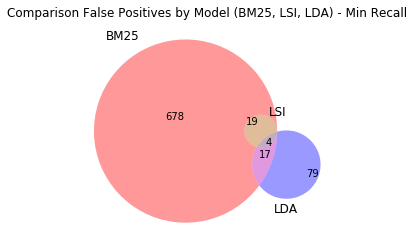

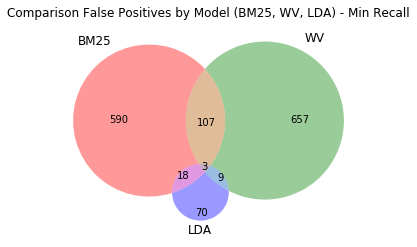

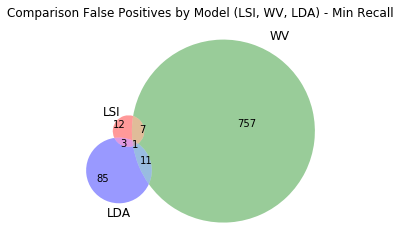

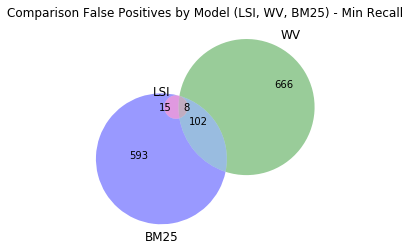

In [16]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Min Recall')
plt.show()

##### Exclusive Cases

In [17]:
print("BM25 Exclusive FP:")
display(bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLSI Exclusive FP:")
display(lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLDA Exclusive FP:")
display(lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set)

print("\n\nWV Exclusive FP:")
display(wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set)

BM25 Exclusive FP:


{('TC_100_TRG', 'BR_1313778_SRC'),
 ('TC_100_TRG', 'BR_1325902_SRC'),
 ('TC_101_TRG', 'BR_1301421_SRC'),
 ('TC_101_TRG', 'BR_1313290_SRC'),
 ('TC_101_TRG', 'BR_1314643_SRC'),
 ('TC_101_TRG', 'BR_1330745_SRC'),
 ('TC_105_TRG', 'BR_1281190_SRC'),
 ('TC_105_TRG', 'BR_1313969_SRC'),
 ('TC_106_TRG', 'BR_1267501_SRC'),
 ('TC_106_TRG', 'BR_1269485_SRC'),
 ('TC_106_TRG', 'BR_1297976_SRC'),
 ('TC_107_TRG', 'BR_1281190_SRC'),
 ('TC_108_TRG', 'BR_1271607_SRC'),
 ('TC_108_TRG', 'BR_1281190_SRC'),
 ('TC_108_TRG', 'BR_1328913_SRC'),
 ('TC_109_TRG', 'BR_1271607_SRC'),
 ('TC_109_TRG', 'BR_1276120_SRC'),
 ('TC_109_TRG', 'BR_1296366_SRC'),
 ('TC_109_TRG', 'BR_1311998_SRC'),
 ('TC_109_TRG', 'BR_1313778_SRC'),
 ('TC_109_TRG', 'BR_1313969_SRC'),
 ('TC_109_TRG', 'BR_1316126_SRC'),
 ('TC_109_TRG', 'BR_1328913_SRC'),
 ('TC_110_TRG', 'BR_1357458_SRC'),
 ('TC_111_TRG', 'BR_1301784_SRC'),
 ('TC_111_TRG', 'BR_1352539_SRC'),
 ('TC_111_TRG', 'BR_1357085_SRC'),
 ('TC_111_TRG', 'BR_1430603_SRC'),
 ('TC_112_TRG', 'BR_



LSI Exclusive FP:


set()



LDA Exclusive FP:


{('TC_112_TRG', 'BR_1297374_SRC'),
 ('TC_113_TRG', 'BR_1312018_SRC'),
 ('TC_113_TRG', 'BR_1353831_SRC'),
 ('TC_114_TRG', 'BR_1312018_SRC'),
 ('TC_114_TRG', 'BR_1353831_SRC'),
 ('TC_115_TRG', 'BR_1278388_SRC'),
 ('TC_116_TRG', 'BR_1312018_SRC'),
 ('TC_117_TRG', 'BR_1312018_SRC'),
 ('TC_117_TRG', 'BR_1353831_SRC'),
 ('TC_118_TRG', 'BR_1278388_SRC'),
 ('TC_118_TRG', 'BR_1297374_SRC'),
 ('TC_118_TRG', 'BR_1353831_SRC'),
 ('TC_119_TRG', 'BR_1353831_SRC'),
 ('TC_120_TRG', 'BR_1287748_SRC'),
 ('TC_120_TRG', 'BR_1313290_SRC'),
 ('TC_122_TRG', 'BR_1287748_SRC'),
 ('TC_144_TRG', 'BR_1320557_SRC'),
 ('TC_145_TRG', 'BR_1320557_SRC'),
 ('TC_149_TRG', 'BR_1320557_SRC'),
 ('TC_14_TRG', 'BR_1267480_SRC'),
 ('TC_150_TRG', 'BR_1320557_SRC'),
 ('TC_151_TRG', 'BR_1320557_SRC'),
 ('TC_166_TRG', 'BR_1257087_SRC'),
 ('TC_166_TRG', 'BR_1283542_SRC'),
 ('TC_166_TRG', 'BR_1287823_SRC'),
 ('TC_174_TRG', 'BR_1323211_SRC'),
 ('TC_175_TRG', 'BR_1323211_SRC'),
 ('TC_176_TRG', 'BR_1323211_SRC'),
 ('TC_178_TRG', 'BR_1



WV Exclusive FP:


{('TC_100_TRG', 'BR_1267501_SRC'),
 ('TC_100_TRG', 'BR_1269348_SRC'),
 ('TC_100_TRG', 'BR_1269485_SRC'),
 ('TC_100_TRG', 'BR_1282759_SRC'),
 ('TC_100_TRG', 'BR_1285328_SRC'),
 ('TC_100_TRG', 'BR_1287384_SRC'),
 ('TC_100_TRG', 'BR_1292566_SRC'),
 ('TC_100_TRG', 'BR_1294887_SRC'),
 ('TC_100_TRG', 'BR_1297686_SRC'),
 ('TC_100_TRG', 'BR_1301056_SRC'),
 ('TC_100_TRG', 'BR_1305676_SRC'),
 ('TC_100_TRG', 'BR_1312018_SRC'),
 ('TC_100_TRG', 'BR_1313290_SRC'),
 ('TC_100_TRG', 'BR_1319119_SRC'),
 ('TC_100_TRG', 'BR_1320557_SRC'),
 ('TC_100_TRG', 'BR_1334844_SRC'),
 ('TC_100_TRG', 'BR_1335992_SRC'),
 ('TC_100_TRG', 'BR_1337682_SRC'),
 ('TC_100_TRG', 'BR_1343256_SRC'),
 ('TC_100_TRG', 'BR_1357085_SRC'),
 ('TC_100_TRG', 'BR_1408361_SRC'),
 ('TC_100_TRG', 'BR_1430603_SRC'),
 ('TC_100_TRG', 'BR_1451475_SRC'),
 ('TC_101_TRG', 'BR_1285328_SRC'),
 ('TC_101_TRG', 'BR_1430603_SRC'),
 ('TC_105_TRG', 'BR_1297976_SRC'),
 ('TC_105_TRG', 'BR_1301784_SRC'),
 ('TC_105_TRG', 'BR_1305737_SRC'),
 ('TC_106_TRG', 'BR_

#### Max Recall

model
bm25          32.54
lda           35.35
lsi           46.99
wordvector    12.62
Name: perc_recall, dtype: float64



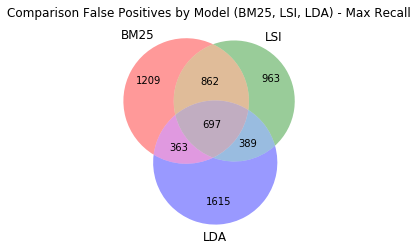

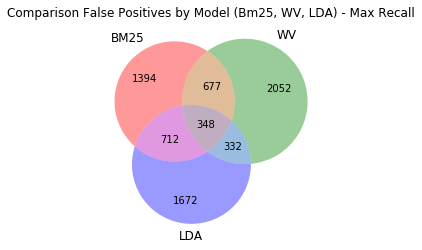

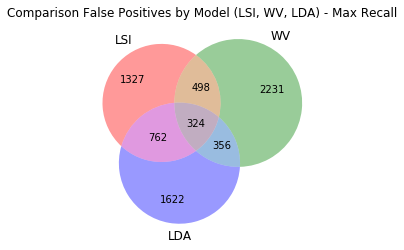

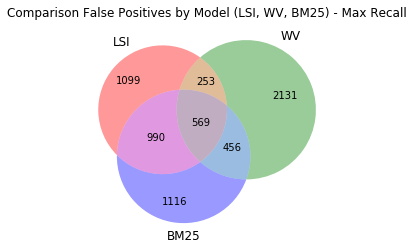

In [18]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [19]:
print("BM25 Exclusive FP:")
display(bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLSI Exclusive FP:")
display(lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLDA Exclusive FP:")
display(lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set)

print("\n\nWV Exclusive FP:")
display(wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set)

BM25 Exclusive FP:


{('TC_100_TRG', 'BR_1297976_SRC'),
 ('TC_100_TRG', 'BR_1311998_SRC'),
 ('TC_101_TRG', 'BR_1269485_SRC'),
 ('TC_101_TRG', 'BR_1287748_SRC'),
 ('TC_101_TRG', 'BR_1297686_SRC'),
 ('TC_101_TRG', 'BR_1297976_SRC'),
 ('TC_101_TRG', 'BR_1301421_SRC'),
 ('TC_101_TRG', 'BR_1301784_SRC'),
 ('TC_101_TRG', 'BR_1311998_SRC'),
 ('TC_101_TRG', 'BR_1313290_SRC'),
 ('TC_101_TRG', 'BR_1316126_SRC'),
 ('TC_101_TRG', 'BR_1408361_SRC'),
 ('TC_102_TRG', 'BR_1305676_SRC'),
 ('TC_103_TRG', 'BR_1305676_SRC'),
 ('TC_105_TRG', 'BR_1313778_SRC'),
 ('TC_106_TRG', 'BR_1287823_SRC'),
 ('TC_106_TRG', 'BR_1313778_SRC'),
 ('TC_108_TRG', 'BR_1289240_SRC'),
 ('TC_109_TRG', 'BR_1289240_SRC'),
 ('TC_109_TRG', 'BR_1294887_SRC'),
 ('TC_109_TRG', 'BR_1296366_SRC'),
 ('TC_109_TRG', 'BR_1299458_SRC'),
 ('TC_109_TRG', 'BR_1313778_SRC'),
 ('TC_109_TRG', 'BR_1323211_SRC'),
 ('TC_109_TRG', 'BR_1334844_SRC'),
 ('TC_110_TRG', 'BR_1276120_SRC'),
 ('TC_110_TRG', 'BR_1287823_SRC'),
 ('TC_110_TRG', 'BR_1290424_SRC'),
 ('TC_111_TRG', 'BR_



LSI Exclusive FP:


{('TC_102_TRG', 'BR_1283542_SRC'),
 ('TC_102_TRG', 'BR_1285041_SRC'),
 ('TC_102_TRG', 'BR_1297336_SRC'),
 ('TC_102_TRG', 'BR_1313778_SRC'),
 ('TC_103_TRG', 'BR_1283542_SRC'),
 ('TC_103_TRG', 'BR_1285041_SRC'),
 ('TC_103_TRG', 'BR_1297336_SRC'),
 ('TC_103_TRG', 'BR_1313778_SRC'),
 ('TC_104_TRG', 'BR_1267501_SRC'),
 ('TC_104_TRG', 'BR_1269485_SRC'),
 ('TC_104_TRG', 'BR_1276120_SRC'),
 ('TC_104_TRG', 'BR_1281190_SRC'),
 ('TC_104_TRG', 'BR_1281493_SRC'),
 ('TC_104_TRG', 'BR_1297336_SRC'),
 ('TC_104_TRG', 'BR_1301784_SRC'),
 ('TC_104_TRG', 'BR_1313290_SRC'),
 ('TC_104_TRG', 'BR_1313969_SRC'),
 ('TC_104_TRG', 'BR_1318903_SRC'),
 ('TC_104_TRG', 'BR_1335538_SRC'),
 ('TC_104_TRG', 'BR_1336227_SRC'),
 ('TC_104_TRG', 'BR_1357085_SRC'),
 ('TC_105_TRG', 'BR_1267501_SRC'),
 ('TC_105_TRG', 'BR_1269485_SRC'),
 ('TC_105_TRG', 'BR_1281493_SRC'),
 ('TC_105_TRG', 'BR_1345687_SRC'),
 ('TC_106_TRG', 'BR_1276120_SRC'),
 ('TC_106_TRG', 'BR_1287384_SRC'),
 ('TC_106_TRG', 'BR_1293308_SRC'),
 ('TC_106_TRG', 'BR_



LDA Exclusive FP:


{('TC_118_TRG', 'BR_1319119_SRC'),
 ('TC_61_TRG', 'BR_1289832_SRC'),
 ('TC_116_TRG', 'BR_1305737_SRC'),
 ('TC_147_TRG', 'BR_1292573_SRC'),
 ('TC_149_TRG', 'BR_1276120_SRC'),
 ('TC_205_TRG', 'BR_1343256_SRC'),
 ('TC_30_TRG', 'BR_1352539_SRC'),
 ('TC_110_TRG', 'BR_1334844_SRC'),
 ('TC_179_TRG', 'BR_1276120_SRC'),
 ('TC_116_TRG', 'BR_1277937_SRC'),
 ('TC_78_TRG', 'BR_1287823_SRC'),
 ('TC_112_TRG', 'BR_1408361_SRC'),
 ('TC_206_TRG', 'BR_1292573_SRC'),
 ('TC_45_TRG', 'BR_1365887_SRC'),
 ('TC_201_TRG', 'BR_1277937_SRC'),
 ('TC_174_TRG', 'BR_1293308_SRC'),
 ('TC_66_TRG', 'BR_1311998_SRC'),
 ('TC_176_TRG', 'BR_1292573_SRC'),
 ('TC_150_TRG', 'BR_1269485_SRC'),
 ('TC_203_TRG', 'BR_1285328_SRC'),
 ('TC_199_TRG', 'BR_1296322_SRC'),
 ('TC_61_TRG', 'BR_1293308_SRC'),
 ('TC_197_TRG', 'BR_1316126_SRC'),
 ('TC_70_TRG', 'BR_1325902_SRC'),
 ('TC_66_TRG', 'BR_1269348_SRC'),
 ('TC_60_TRG', 'BR_1301421_SRC'),
 ('TC_67_TRG', 'BR_1269485_SRC'),
 ('TC_112_TRG', 'BR_1337682_SRC'),
 ('TC_204_TRG', 'BR_1301784_SR



WV Exclusive FP:


{('TC_122_TRG', 'BR_1339497_SRC'),
 ('TC_174_TRG', 'BR_1313778_SRC'),
 ('TC_85_TRG', 'BR_1257087_SRC'),
 ('TC_186_TRG', 'BR_1343256_SRC'),
 ('TC_34_TRG', 'BR_1345687_SRC'),
 ('TC_105_TRG', 'BR_1264988_SRC'),
 ('TC_59_TRG', 'BR_1343256_SRC'),
 ('TC_149_TRG', 'BR_1335992_SRC'),
 ('TC_46_TRG', 'BR_1318903_SRC'),
 ('TC_128_TRG', 'BR_1287687_SRC'),
 ('TC_93_TRG', 'BR_1313290_SRC'),
 ('TC_129_TRG', 'BR_1318903_SRC'),
 ('TC_139_TRG', 'BR_1313969_SRC'),
 ('TC_128_TRG', 'BR_1297374_SRC'),
 ('TC_122_TRG', 'BR_1281190_SRC'),
 ('TC_107_TRG', 'BR_1323211_SRC'),
 ('TC_33_TRG', 'BR_1285041_SRC'),
 ('TC_130_TRG', 'BR_1320557_SRC'),
 ('TC_133_TRG', 'BR_1306639_SRC'),
 ('TC_198_TRG', 'BR_1278388_SRC'),
 ('TC_99_TRG', 'BR_1296366_SRC'),
 ('TC_135_TRG', 'BR_1290424_SRC'),
 ('TC_205_TRG', 'BR_1291770_SRC'),
 ('TC_129_TRG', 'BR_1313969_SRC'),
 ('TC_83_TRG', 'BR_1282759_SRC'),
 ('TC_139_TRG', 'BR_1330745_SRC'),
 ('TC_173_TRG', 'BR_1287687_SRC'),
 ('TC_100_TRG', 'BR_1269348_SRC'),
 ('TC_28_TRG', 'BR_1297976_S

In [20]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 2911
LDA FP Amount: 3064
BM25 FP Amount: 3131
WV FP Amount: 3409
